In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import random
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn

In [ ]:
dataset_path = 'drive/MyDrive/Data/genres_original'

In [ ]:
def save_mfccs(data_path, hop_length=512, sample_rate=22050, track_duration=30, num_segments=10):
  data = {'mapping': [], 'labels': [], 'mfcc': []}

  samples_per_track = sample_rate*track_duration
  samples_per_segment = int(samples_per_track / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not data_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)

            for f in filenames:
              file_path = os.path.join(dirpath, f)
              signal, sample_rate = librosa.load(file_path, sr = sample_rate)

              for d in range(num_segments):
                    start = samples_per_segment * d
                    finish =  start + samples_per_segment
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr = sample_rate, n_mfcc = 13, n_fft = 2048, hop_length = hop_length)
                    mfcc = mfcc.T

                    if len(mfcc) == num_mfcc_vectors_per_segment:
                      #this will discard wrong mfcc lengths
                      data["mfcc"].append(mfcc.tolist())
                      data["labels"].append(i-1) 

  X = np.array(data["mfcc"])
  Y = np.array(data["labels"])
  z = data["mapping"]
  return X, Y, z

In [ ]:
X, y, label_map = save_mfccs(dataset_path)
#for 10 segments takes about 3 mins

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=25)

Epoch 1/25
250/250 [==============================] - 4s 16ms/step - loss: 10.0881 - accuracy: 0.3229 - val_loss: 4.6610 - val_accuracy: 0.3473
Epoch 2/25
250/250 [==============================] - 3s 13ms/step - loss: 3.2430 - accuracy: 0.4214 - val_loss: 3.1345 - val_accuracy: 0.3899
Epoch 3/25
250/250 [==============================] - 3s 13ms/step - loss: 2.1002 - accuracy: 0.4266 - val_loss: 2.1439 - val_accuracy: 0.3839
Epoch 4/25
250/250 [==============================] - 3s 12ms/step - loss: 1.6382 - accuracy: 0.4661 - val_loss: 2.1653 - val_accuracy: 0.3879
Epoch 5/25
250/250 [==============================] - 3s 12ms/step - loss: 1.4696 - accuracy: 0.5161 - val_loss: 2.0920 - val_accuracy: 0.4149
Epoch 6/25
250/250 [==============================] - 3s 12ms/step - loss: 1.3150 - accuracy: 0.5611 - val_loss: 2.1132 - val_accuracy: 0.4244
Epoch 7/25
250/250 [==============================] - 4s 16ms/step - loss: 1.2060 - accuracy: 0.5918 - val_loss: 1.9573 - val_accuracy: 0.449

In [ ]:
def plot_history(history):

  plt.figure(figsize=(6,3))
  #create accuracy sublpot
  plt.plot(history.history["accuracy"], label="train accuracy")
  plt.plot(history.history["val_accuracy"], label="test accuracy")
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  #axs[0].legend(loc="lower right")
  plt.title('Accuracy Comparison')
  plt.legend()
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(6,3))
  #create error sublpot
  plt.plot(history.history["loss"], label="train error")
  plt.plot(history.history["val_loss"], label="test error")
  plt.ylabel('Error')
  plt.xlabel('Epoch')
  #axs[1]wlegend(loc="upper right")
  plt.title('Error Comparison')
  plt.legend()
  plt.tight_layout()
  plt.show()

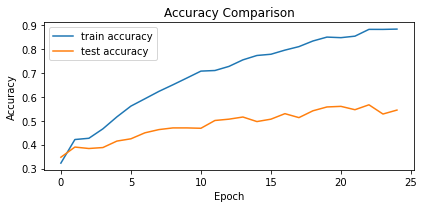

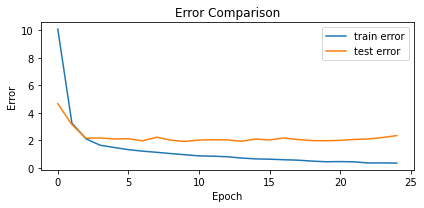

In [ ]:
plot_history(history)


In [ ]:
#overfitting:

In [ ]:
model_regularized = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
250/250 [==============================] - 7s 20ms/step - loss: 22.9832 - accuracy: 0.1631 - val_loss: 3.4482 - val_accuracy: 0.2462
Epoch 2/50
250/250 [==============================] - 5s 21ms/step - loss: 6.1214 - accuracy: 0.1654 - val_loss: 3.4619 - val_accuracy: 0.1481
Epoch 3/50
250/250 [==============================] - 5s 21ms/step - loss: 4.2478 - accuracy: 0.1689 - val_loss: 3.4803 - val_accuracy: 0.1251
Epoch 4/50
250/250 [==============================] - 5s 19ms/step - loss: 3.8315 - accuracy: 0.1685 - val_loss: 3.4780 - val_accuracy: 0.1296
Epoch 5/50
250/250 [==============================] - 5s 19ms/step - loss: 3.6333 - accuracy: 0.1706 - val_loss: 3.4448 - val_accuracy: 0.1491
Epoch 6/50
250/250 [==============================] - 8s 32ms/step - loss: 3.5713 - accuracy: 0.1699 - val_loss: 3.4274 - val_accuracy: 0.1522
Epoch 7/50
250/250 [==============================] - 7s 28ms/step - loss: 3.5023 - accuracy: 0.1805 - val_loss: 3.3938 - val_accuracy: 0.166

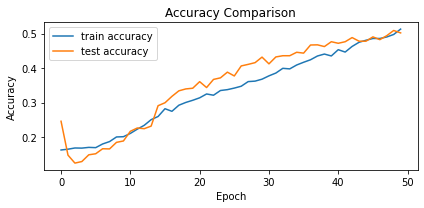

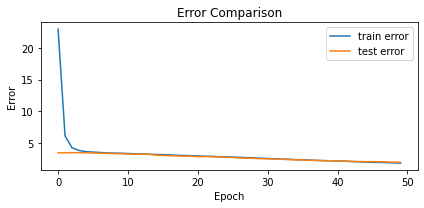

In [ ]:
plot_history(history)
#50 epochs may not be enough here, so well try 100

In [ ]:
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
250/250 [==============================] - 5s 21ms/step - loss: 1.8226 - accuracy: 0.5119 - val_loss: 1.9508 - val_accuracy: 0.4900
Epoch 2/100
250/250 [==============================] - 8s 33ms/step - loss: 1.7977 - accuracy: 0.5217 - val_loss: 1.9365 - val_accuracy: 0.5070
Epoch 3/100
250/250 [==============================] - 5s 20ms/step - loss: 1.7662 - accuracy: 0.5225 - val_loss: 1.9461 - val_accuracy: 0.5265
Epoch 4/100
250/250 [==============================] - 5s 19ms/step - loss: 1.7318 - accuracy: 0.5358 - val_loss: 1.9280 - val_accuracy: 0.5180
Epoch 5/100
250/250 [==============================] - 5s 19ms/step - loss: 1.7174 - accuracy: 0.5378 - val_loss: 1.8932 - val_accuracy: 0.5090
Epoch 6/100
250/250 [==============================] - 5s 21ms/step - loss: 1.6861 - accuracy: 0.5442 - val_loss: 1.9166 - val_accuracy: 0.5195
Epoch 7/100
250/250 [==============================] - 5s 19ms/step - loss: 1.6665 - accuracy: 0.5548 - val_loss: 1.9144 - val_accuracy:

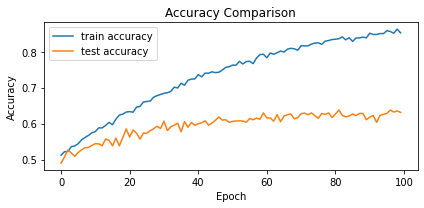

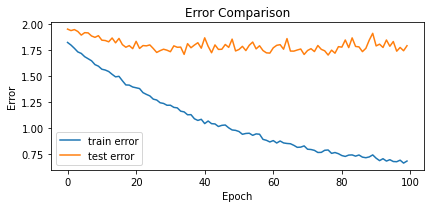

In [ ]:
plot_history(history)

In [ ]:
#still have overfitting

In [ ]:
#CNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 14s 69ms/step - loss: 2.3590 - accuracy: 0.2344 - val_loss: 1.7945 - val_accuracy: 0.3578
Epoch 2/50
188/188 [==============================] - 12s 65ms/step - loss: 1.8069 - accuracy: 0.3762 - val_loss: 1.4867 - val_accuracy: 0.4599
Epoch 3/50
188/188 [==============================] - 12s 66ms/step - loss: 1.6282 - accuracy: 0.4250 - val_loss: 1.3901 - val_accuracy: 0.4873
Epoch 4/50
188/188 [==============================] - 13s 68ms/step - loss: 1.5352 - accuracy: 0.4612 - val_loss: 1.3347 - val_accuracy: 0.5127
Epoch 5/50
188/188 [==============================] - 13s 67ms/step - loss: 1.4376 - accuracy: 0.4841 - val_loss: 1.2796 - val_accuracy: 0.5347
Epoch 6/50
188/188 [==============================] - 13s 68ms/step - loss: 1.3723 - accuracy: 0.5078 - val_loss: 1.2078 - val_accuracy: 0.5594
Epoch 7/50
188/188 [==============================] - 12s 66ms/step - loss: 1.3267 - accuracy: 0.5270 - val_loss: 1.1607 - val_accuracy:

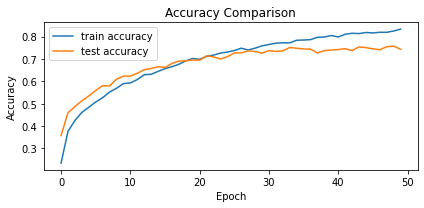

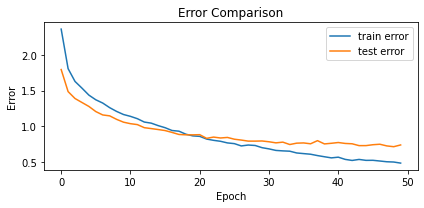

In [ ]:
plot_history(history)

In [ ]:
label_map

['jazz',
 'metal',
 'disco',
 'reggae',
 'classical',
 'country',
 'rock',
 'hiphop',
 'blues',
 'pop']

In [ ]:
labels_dict = {
    0: 'jazz',
    1: 'metal',
    2: 'disco',
    3: 'reggae',
    4: 'classical',
    5: 'country',
    6: 'rock',
    7: 'hiphop',
    8: 'blues',
    9: 'pop'
}

In [ ]:
X_to_predict = X_test[10]
y_to_predict = y_test[10]

In [ ]:
y_to_predict

8

In [ ]:
X_to_predict = X_to_predict[np.newaxis, ...]

In [ ]:
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)
int(predicted_index)

8

In [ ]:
for n in range(10):

  i = random.randint(0,len(X_test))
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 1
Predicted Genre: 1

Real Genre: 1
Predicted Genre: 1

Real Genre: 2
Predicted Genre: 1

Real Genre: 7
Predicted Genre: 7

Real Genre: 0
Predicted Genre: 0

Real Genre: 4
Predicted Genre: 4

Real Genre: 3
Predicted Genre: 5

Real Genre: 0
Predicted Genre: 0

Real Genre: 8
Predicted Genre: 8

Real Genre: 0
Predicted Genre: 0


In [226]:
X.shape

(9986, 130, 13)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [224]:
predictions = model_cnn.predict(X_test)

In [225]:
len(predictions)

1998

In [228]:
y_true = []
y_predict = []
for i in range(len(predictions)):
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]
  X_to_predict = X_to_predict[np.newaxis, ...]
  prediction = model_cnn.predict(X_to_predict)
  predicted_index = np.argmax(prediction, axis=1)
  y_true.append(y_to_predict)
  y_predict.append(int(predicted_index))

In [229]:
cf_matrix = confusion_matrix(y_true, y_predict)
cf_matrix

array([[173,   0,   0,   0,   9,   5,   0,   0,   2,   0],
       [  0, 187,   1,   1,   0,   2,   2,   2,   3,   1],
       [  1,   2, 178,   1,   1,   5,   3,   6,   1,   4],
       [  1,   2,  12, 158,   0,   1,   1,  10,   1,   4],
       [  5,   0,   0,   1, 208,   1,   0,   0,   0,   0],
       [  7,   1,   2,   3,   1, 179,   7,   1,   2,   0],
       [  7,  17,  20,  10,   2,  24, 109,   1,   7,   6],
       [  1,   7,   4,  10,   0,   1,   3, 168,   3,   5],
       [  7,   7,   8,   5,   0,   9,   1,   2, 163,   1],
       [  2,   0,   9,   4,   0,   7,   1,   4,   0, 165]])

In [230]:
confusion_df = pd.DataFrame(cf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,173,0,0,0,9,5,0,0,2,0
1,0,187,1,1,0,2,2,2,3,1
2,1,2,178,1,1,5,3,6,1,4
3,1,2,12,158,0,1,1,10,1,4
4,5,0,0,1,208,1,0,0,0,0
5,7,1,2,3,1,179,7,1,2,0
6,7,17,20,10,2,24,109,1,7,6
7,1,7,4,10,0,1,3,168,3,5
8,7,7,8,5,0,9,1,2,163,1
9,2,0,9,4,0,7,1,4,0,165


In [231]:
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,metal,disco,reggae,classical,country,rock,hiphop,blues,pop
jazz,173,0,0,0,9,5,0,0,2,0
metal,0,187,1,1,0,2,2,2,3,1
disco,1,2,178,1,1,5,3,6,1,4
reggae,1,2,12,158,0,1,1,10,1,4
classical,5,0,0,1,208,1,0,0,0,0
country,7,1,2,3,1,179,7,1,2,0
rock,7,17,20,10,2,24,109,1,7,6
hiphop,1,7,4,10,0,1,3,168,3,5
blues,7,7,8,5,0,9,1,2,163,1
pop,2,0,9,4,0,7,1,4,0,165


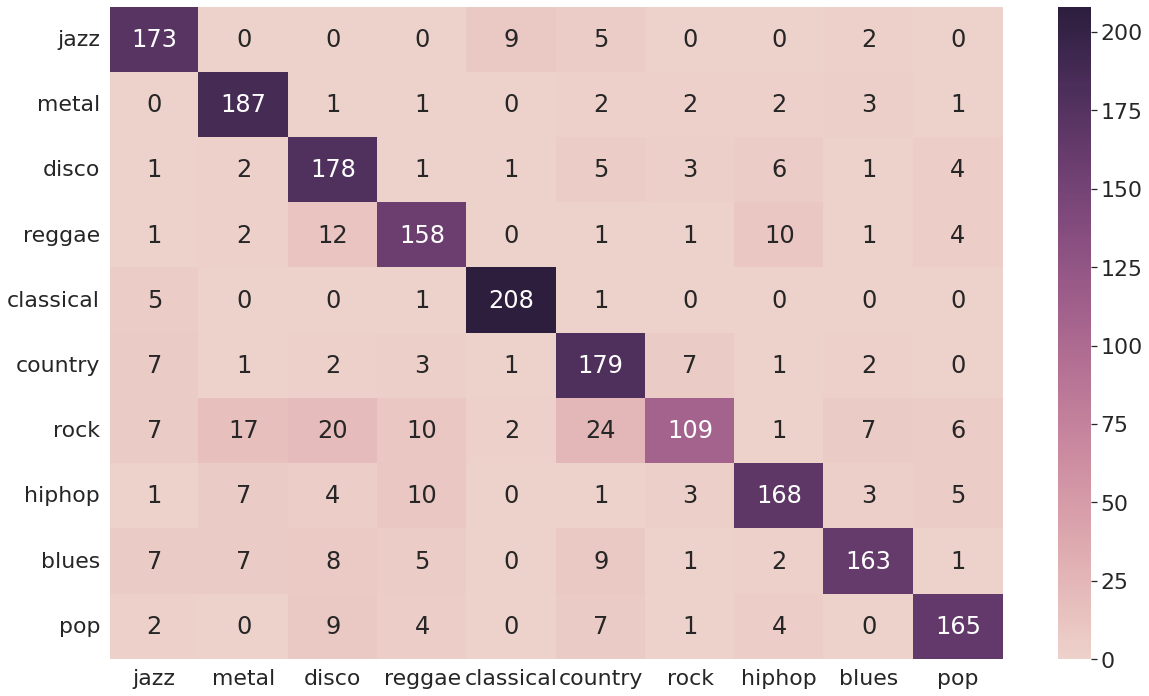

In [242]:
plt.figure(figsize = (20,12))
sn.heatmap(confusion_df, annot=True, cmap=sn.cubehelix_palette(200), fmt='g')
#actual values are on the y axis and predicted values are on the x axis